In [ ]:
!pip install dython

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as ss
import dython
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [46]:
df = pd.read_csv("soybean-large_data.csv", na_values="?")

# Сделать EDA
Взглянем на данные, хоть что там за переменные такие

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             307 non-null    object 
 1   date             306 non-null    float64
 2   plant-stand      299 non-null    float64
 3   precip           296 non-null    float64
 4   temp             300 non-null    float64
 5   hail             266 non-null    float64
 6   crop-hist        306 non-null    float64
 7   area-damaged     306 non-null    float64
 8   severity         266 non-null    float64
 9   seed-tmt         266 non-null    float64
 10  germination      271 non-null    float64
 11  plant-growth     306 non-null    float64
 12  leaves           307 non-null    int64  
 13  leafspots-halo   282 non-null    float64
 14  leafspots-marg   282 non-null    float64
 15  leafspot-size    282 non-null    float64
 16  leaf-shread      281 non-null    float64
 17  leaf-malf       

In [47]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 0 to 289
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             266 non-null    object 
 1   date             266 non-null    float64
 2   plant-stand      266 non-null    float64
 3   precip           266 non-null    float64
 4   temp             266 non-null    float64
 5   hail             266 non-null    float64
 6   crop-hist        266 non-null    float64
 7   area-damaged     266 non-null    float64
 8   severity         266 non-null    float64
 9   seed-tmt         266 non-null    float64
 10  germination      266 non-null    float64
 11  plant-growth     266 non-null    float64
 12  leaves           266 non-null    int64  
 13  leafspots-halo   266 non-null    float64
 14  leafspots-marg   266 non-null    float64
 15  leafspot-size    266 non-null    float64
 16  leaf-shread      266 non-null    float64
 17  leaf-malf       

In [48]:
df = df.dropna()


Если дропнуть все строки с хоть одним NA, остаётся более 86% данных, так что норм, идём дальше. Теперь уже можно спокойно смотреть на данные.

Для данных построим барплоты.

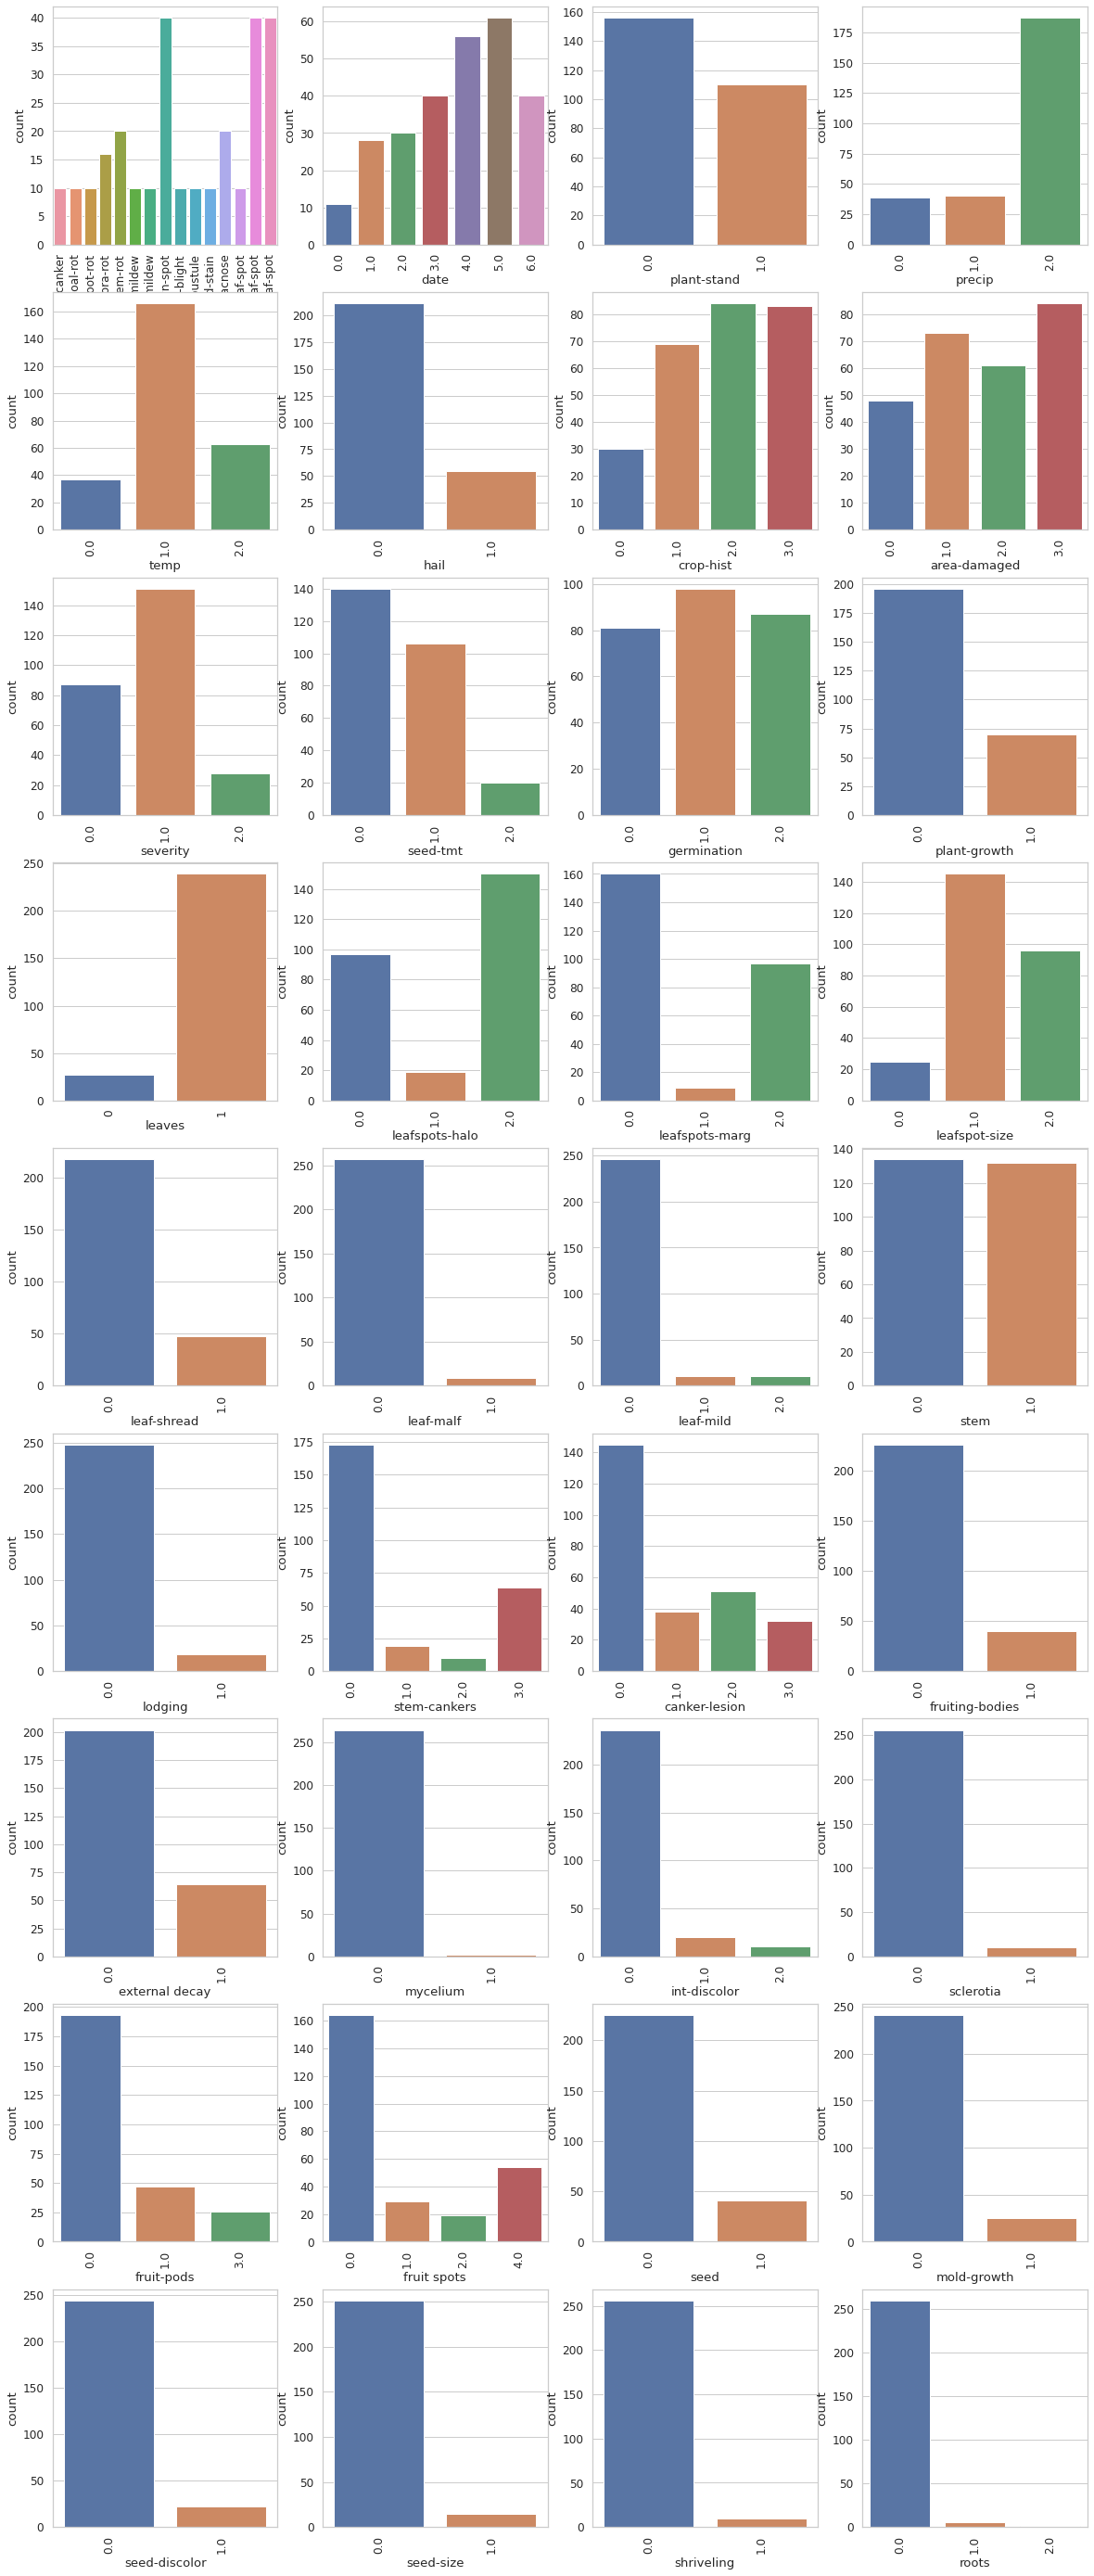

In [31]:
categorial = list(df)

fig, ax = plt.subplots(9, 4, figsize=(20, 50))
for variable, subplot in zip(categorial, ax.flatten()):
    sns.countplot(df[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

In [33]:
Для составления матрицы и хитмэпа ассоциаций я нарыла прикольную библиотеку dython, пользовалась ей.

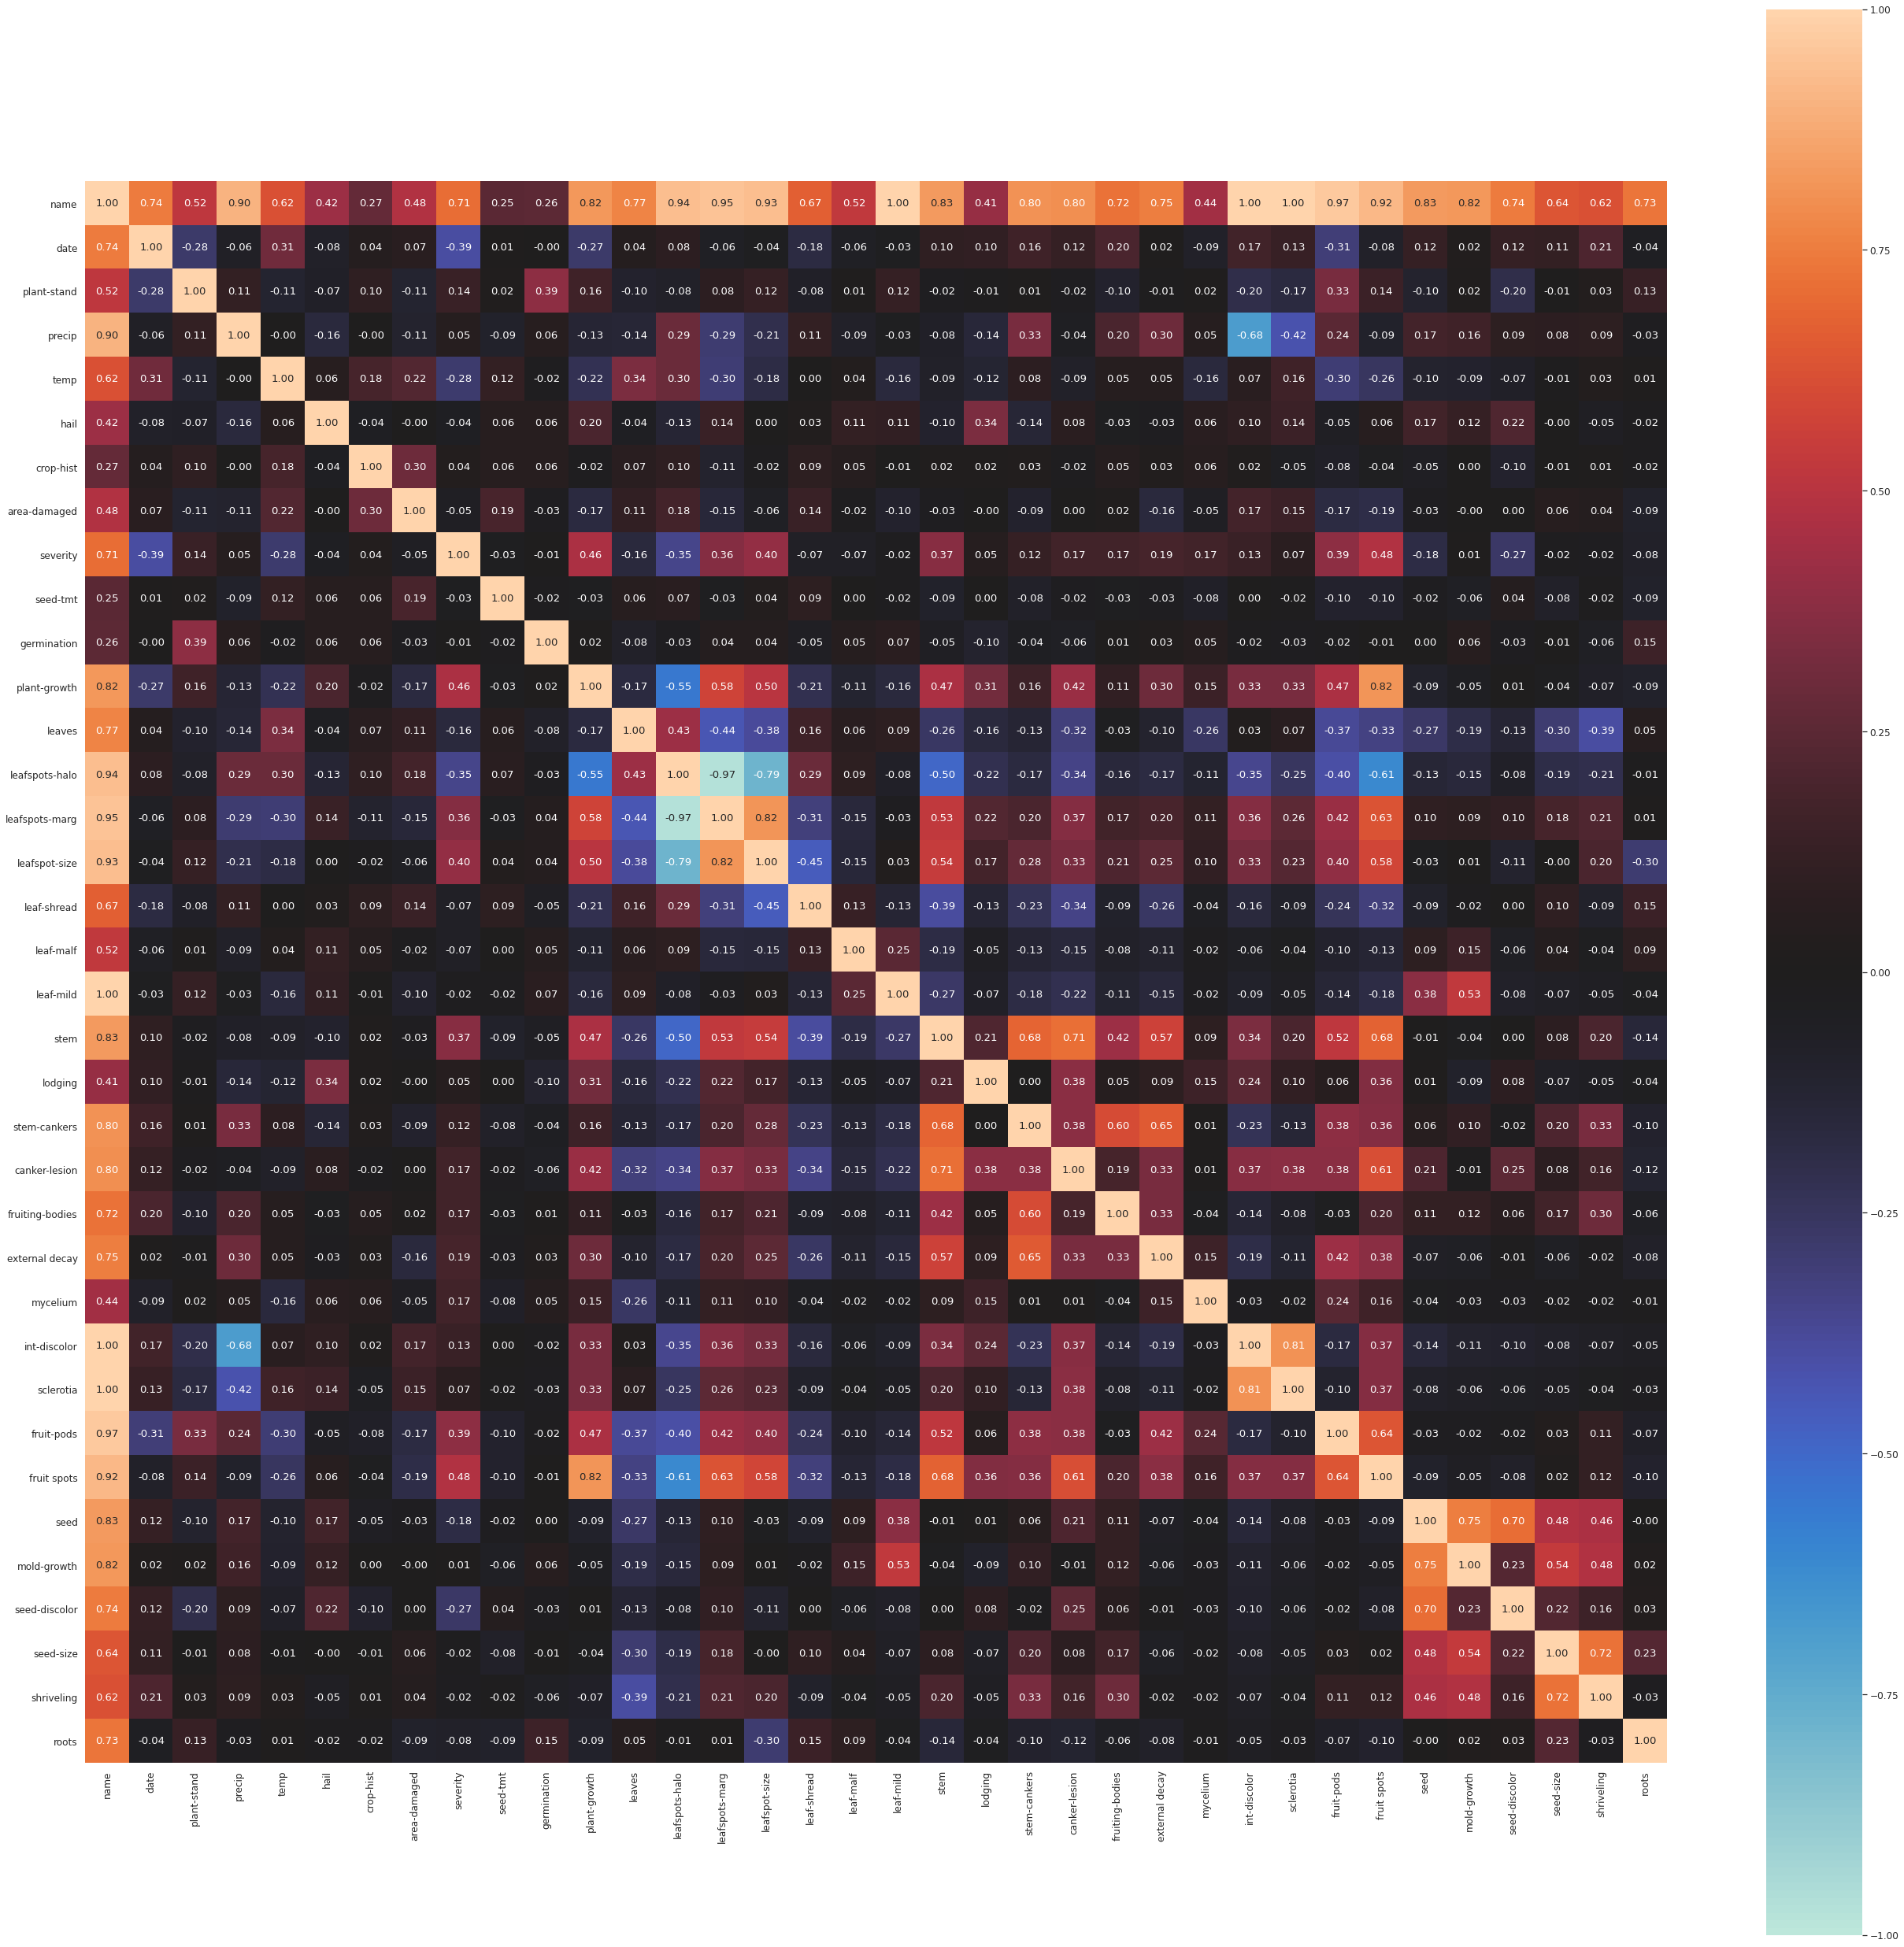

{'corr':                      name      date  plant-stand    precip      temp  \
 name             1.000000  0.743115     0.519887  0.901089  0.619446   
 date             0.743115  1.000000    -0.276397 -0.064487  0.306385   
 plant-stand      0.519887 -0.276397     1.000000  0.112157 -0.110376   
 precip           0.901089 -0.064487     0.112157  1.000000 -0.003940   
 temp             0.619446  0.306385    -0.110376 -0.003940  1.000000   
 hail             0.422906 -0.081346    -0.070579 -0.159177  0.055578   
 crop-hist        0.274409  0.043955     0.099779 -0.002085  0.183873   
 area-damaged     0.482701  0.068234    -0.109997 -0.105603  0.221950   
 severity         0.710355 -0.391065     0.140577  0.048159 -0.283291   
 seed-tmt         0.246875  0.013052     0.019652 -0.091089  0.115475   
 germination      0.255866 -0.000104     0.389367  0.055778 -0.020222   
 plant-growth     0.822623 -0.274636     0.156935 -0.127179 -0.223443   
 leaves           0.766674  0.044832    -0.

In [40]:
dython.nominal.associations(df, theil_u=True, figsize=(45, 45))

Отсюда видно прекрасно, что переменная "name" скореллирована с ОЧ большим кол-вом переменных (что логично), но её-то мы и будем предсказывать.
Остальые скоррелированные:
* "leafspots marg" - "leafspots halo" -0.97
* "leafsplot size" - "leafspots marg"- 0.82
* "leafspots size" - "leafspots halo" - 0.79
* "fruit spota" - "plant grouth" - 0.82
* "int discolor" - "sclerotia" - 0.81

Мой подход - из пары таких коррелированых удалять ту фичу,которая менее скоррелирвоана с name.
* "leafspots marg" 0.95 >  "leafspots halo" 0.94
* "leafspots marg" 0.95 >  "leafsplot size" 0.93
* "fruit spota" 0.92 > "plant grouth" 0.82
* "int discolor" 1 = "sclerotia" 1 , уф, вот тут сложновато, оставлю их обе, раз они так круто скоррелированы с "name"

In [51]:
df = df.drop("leafspots-halo", axis=1)
df = df.drop("leafspot-size", axis=1)
df = df.drop("plant-growth", axis=1)

# Разделите ваш датасет на тестовую и тренировочную выборки

In [68]:
X = df.drop(["name"], axis = 1).values
y = df["name"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0, stratify=y)

# Обучите ваш классификатор

In [72]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Посчитаем F1-меру. Она довольно хороша!

In [77]:
metrics.f1_score(y_test, y_pred, average="macro")

0.8947401837928154

По матрице неточностей можно увидеть конкретные слабые места в данном предсказании, но в целом всё не так плохо!

In [78]:
metrics.confusion_matrix(y_test, y_pred)

array([[11,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0],
       [ 4,  2,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  0

Ищем топ признаков!

In [90]:
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

indices = indices[:15]

features = list(df.columns[1:])

print("Top 3 best features for classification:")

important_features_low = []
for i in range(3):
    if importances[indices[i]] > 0:
        important_features_low.append(features[indices[i]])
        print("{}. feature: {}; importance: {}".format(i+1, features[indices[i]], importances[indices[i]]))

Top 3 best features for classification:
1. feature: date; importance: 0.09474807031926737
2. feature: leafspots-marg; importance: 0.07431295793372762
3. feature: precip; importance: 0.060444635111482986


ТЕПЕРЬ ГРИД СЁРЧ

In [97]:
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,12],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [102]:
best_cv = CV_rfc.best_estimator_
best_cv.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [105]:
y_pred_CV = best_cv.predict(X_test)
print("f1-мера:{}".format(metrics.f1_score(y_test, y_pred_CV, average="macro")))

f1-мера:0.9098830409356726


Ну, лучший классификатор в итоге конечно тот, который был выбран грид сёрчем